PY 452 Project \\
Ryan Branagan & Jared Kempton

#Prep Work

##Definitions

In [ ]:
import numpy as np
import matplotlib.pyplot as p
import pandas as pd
from scipy.integrate import simps
from scipy.stats import linregress as linreg
!pip install colour-science
import colour as col

#Define definitions
def gauss(x,al,mu,sig1,sig2):
  if type(x) == type(np.zeros(1)):
    Out = np.zeros_like(x)
    for i in range(len(x)):
      if x[i] < mu:
        Out[i] = al*np.exp(((x[i]-mu)**2)/(-2*(sig1**2)))
      if x[i] >= mu:
        Out[i] = al*np.exp(((x[i]-mu)**2)/(-2*(sig2**2)))
    return Out
  else:
    if x < mu:
      return al*np.exp(((x-mu)**2)/(-2*(sig1**2)))
    if x >= mu:
      return al*np.exp(((x-mu)**2)/(-2*(sig2**2)))

def xbar(lam):
  return gauss(lam,(1.056),(599.8),(37.9),(31.0)) + gauss(lam,(0.362),(442.0),(16.0),(26.7)) + gauss(lam,(-0.065),(501.1),(20.4),(26.2))

def ybar(lam):
  return gauss(lam,(0.821),(568.8),(46.9),(40.5)) + gauss(lam,(0.286),(530.9),(16.3),(31.1))

def zbar(lam):
  return gauss(lam,(1.217),(437.0),(11.8),(36.0)) + gauss(lam,(0.681),(459.0),(26.0),(13.8))

def ColorCoord(lam_list,spec_list):
  #Compute our integrands
  IntX = spec_list*xbar(lam_list)
  IntY = spec_list*ybar(lam_list)
  IntZ = spec_list*zbar(lam_list)
  
  #Integrate to find X,Y, and Z
  X = simps(IntX,lam_list)
  Y = simps(IntY,lam_list)
  Z = simps(IntZ,lam_list)

  xc = X/(X + Y + Z)
  yc = Y/(X + Y + Z)

  return xc,yc#,X,Y,Z

#Boundary Intersect Points - Wavelengths corresponding to where the lines x=y=(1/3) intersect the locus
BIPW1 = 491.7172
BIP1 = col.XYZ_to_xy(col.wavelength_to_XYZ(BIPW1))
BIPW2 = 554.4362
BIP2 = col.XYZ_to_xy(col.wavelength_to_XYZ(BIPW2))
BIPW3 = 610.2158
BIP3 = col.XYZ_to_xy(col.wavelength_to_XYZ(BIPW3))
BIP4 = np.array([(1/3),0.0789099596143])
BIPW5 = 493.885
BIP5 = col.XYZ_to_xy(col.wavelength_to_XYZ(BIPW5))
BIPW6 = 569.677
BIP6 = col.XYZ_to_xy(col.wavelength_to_XYZ(BIPW6))

#Preliminary calculation of slopes
Point380 = col.XYZ_to_xy(col.wavelength_to_XYZ(380))
Point700 = col.XYZ_to_xy(col.wavelength_to_XYZ(700))
WhitePoint = np.array([(1/3),(1/3)])
LinReg380 = linreg([Point380[0],WhitePoint[0]],[Point380[1],WhitePoint[1]])
Slope380 = LinReg380[0]
LinReg700 = linreg([Point700[0],WhitePoint[0]],[Point700[1],WhitePoint[1]])
Slope700 = LinReg700[0]
LinRegBot = linreg([Point380[0],Point700[0]],[Point380[1],Point700[1]])
SlopeBot = LinRegBot[0]
InterBot = LinRegBot[1]

def ColorQuality(xy,eps):
  #Define Values
  Subx = xy[0]
  Suby = xy[1]
  if Subx == (1/3):
    pass
  else:
    SubLinReg = linreg([Subx,WhitePoint[0]],[Suby,WhitePoint[1]])
    SubSlope = SubLinReg[0]
    SubInter = SubLinReg[1]
  Acc = int(1/eps)
  Queue = np.zeros((2,7)) ### Queue lets me change the inputs for finding dominant and complementary wavelengths. They are as follows; Queue[:,0] = Start point of boundary, Queue[:,1] = End point of boundary, Queue[:,2] = Left x point of line, Queue[:,3] = Right x point of line, Queue[:,4] = The output wavelength, Queue[:,5] = Whether to try and calculate a wavelength or not (True by default), Queue[:,6] = Whether the boundary is the bottom or not (False by default)
  Queue[:,5] = True
  Queue[:,6] = False
  Awkward = 0.0

  #Preliminary check
  if np.abs(Subx - (1/3)) < (10**(-4)) and np.abs(Suby - (1/3)) < (10**(-4)):
    print('The point you have given is the "white point" and has equal amounts of all wavelengths. This means there is not a dominant or complementary wavelength and the color purity is 0.')
    return np.nan,np.nan,0.0
  if np.abs(Subx - (1/3)) < (10**(-4)) and Suby > (1/3):
    print('The point you have given has a complementary wavelength that does not exist and is on the "line of purples".')
    D1 = np.linalg.norm(xy - WhitePoint)
    D2 = np.linalg.norm(BIP2 - WhitePoint)
    return BIPW2,np.nan,(D1/D2)
  if np.abs(Subx - (1/3)) < (10**(-4)) and Suby < (1/3):
    print('The point you have given has a dominant wavelength that does not exist and is on the "line of purples".')
    D1 = np.linalg.norm(xy - WhitePoint)
    D2 = np.linalg.norm(BIP4 - WhitePoint)
    return np.nan,BIPW2,(D1/D2)
  if Subx < (1/3) and np.abs(Suby - (1/3)) < (10**(-4)):
    D1 = np.linalg.norm(xy - WhitePoint)
    D2 = np.linalg.norm(BIP1 - WhitePoint)
    return BIPW1,BIPW3,(D1/D2)
  if Subx > (1/3) and np.abs(Suby - (1/3)) < (10**(-4)):
    D1 = np.linalg.norm(xy - WhitePoint)
    D2 = np.linalg.norm(BIP3 - WhitePoint)
    return BIPW3,BIPW1,(D1/D2)
  if np.abs(SubSlope - Slope380) < (10**(-4)) and Suby > (1/3):
    D1 = np.linalg.norm(xy - WhitePoint)
    D2 = np.linalg.norm(BIP6 - WhitePoint)
    return BIPW6,380.0,(D1/D2)
  if np.abs(SubSlope - Slope380) < (10**(-4)) and Suby < (1/3):
    D1 = np.linalg.norm(xy - WhitePoint)
    D2 = np.linalg.norm(Point380 - WhitePoint)
    return 380.0,BIPW6,(D1/D2)
  if np.abs(SubSlope - Slope700) < (10**(-4)) and Suby > (1/3):
    D1 = np.linalg.norm(xy - WhitePoint)
    D2 = np.linalg.norm(BIP5 - WhitePoint)
    return BIPW5,700.0,(D1/D2)
  if np.abs(SubSlope - Slope700) < (10**(-4)) and Suby < (1/3):
    D1 = np.linalg.norm(xy - WhitePoint)
    D2 = np.linalg.norm(Point700 - WhitePoint)
    return 700.0,BIPW5,(D1/D2)

  #Find what sextant the point is in
  if Slope700 < SubSlope and SubSlope < Slope380 and Subx < (1/3):#Sextant 1
    Queue[0,0] = 380.0
    Queue[0,1] = BIPW5
    Queue[0,2] = 0.0
    Queue[0,3] = Subx
    Queue[1,0] = BIPW6
    Queue[1,1] = 700.0
    Queue[1,2] = BIP6[0] - 0.01
    Queue[1,3] = Point700[0] + 0.01
  if Slope700 < SubSlope and SubSlope < Slope380 and Subx > (1/3):#Sextant 4
    Queue[0,0] = BIPW6
    Queue[0,1] = 700.0
    Queue[0,2] = Subx
    Queue[0,3] = Point700[0] + 0.01
    Queue[1,0] = 380.0
    Queue[1,1] = BIPW5
    Queue[1,2] = BIP5[0] - 0.01
    Queue[1,3] = Point380[0] + 0.01
  if SubSlope < Slope700 and Subx < (1/3):#Sextant 2
    Queue[0,0] = BIPW5
    Queue[0,1] = BIPW2
    Queue[0,2] = 0.0
    Queue[0,3] = (1/3)
    print('The point you have given has a complementary wavelength that does not exist.')
    Queue[1,4] = np.nan
    Queue[1,5] = False
  if SubSlope < Slope700 and Subx > (1/3):#Sextant 5
    Queue[0,0] = (1/3)
    Queue[0,1] = Point700[0]
    Queue[0,2] = Subx
    Queue[0,3] = Point700[0]
    print('The point you have given has a dominant wavelength that does not exist.')
    Queue[0,4] = np.nan
    Queue[0,6] = True
    Queue[1,0] = BIPW5
    Queue[1,1] = BIPW6
    Queue[1,2] = 0.0
    Queue[1,3] = (1/3)
  if SubSlope > Slope380 and Subx < (1/3):#Sextant 6
    Queue[0,0] = Point380[0]
    Queue[0,1] = (1/3)
    Queue[0,2] = Point380[0] - 0.01
    Queue[0,3] = Subx
    print('The point you have given has a dominant wavelength that does not exist.')
    Queue[0,4] = np.nan
    Queue[0,6] = True
    Queue[1,0] = BIPW2
    Queue[1,1] = BIPW6
    Queue[1,2] = (1/3)
    Queue[1,3] = BIP6[0] + 0.01
  if SubSlope > Slope380 and Subx > (1/3):#Sextant 3
    Queue[0,0] = BIPW2
    Queue[0,1] = BIPW6
    Queue[0,2] = (1/3)
    Queue[0,3] = BIP6[0] + 0.01
    print('The point you have given has a complementary wavelength that does not exist.')
    Queue[1,4] = np.nan
    Queue[1,5] = False

  #Find Dominant and Complementary wavelengths
  for k in range(len(Queue)):
    if Queue[k,5]:
      #Calcualte line and boundary piece
      if Queue[k,6]:
        Botx = np.linspace(Queue[k,0],Queue[k,1],Acc)
        Find = np.zeros((len(Botx),2))
        Find[:,0] = Botx
        Find[:,1] = SlopeBot*Botx + InterBot
      else:
        FLs = np.linspace(Queue[k,0],Queue[k,1],(((int(Queue[k,1])-int(Queue[k,0]))*Acc)+1))
        Find = np.zeros((len(FLs),2))
        for i in range(len(FLs)):
          Find[i] = col.XYZ_to_xy(col.wavelength_to_XYZ(FLs[i]))
      
      Linex = np.linspace(Queue[k,2],Queue[k,3],Acc)
      Liney = SubSlope*Linex + SubInter
      Line = np.zeros((len(Linex),2))
      Line[:,0] = Linex
      Line[:,1] = Liney

      #Calculate distance to minimize
      Diff = np.zeros((len(Find),len(Line)))
      for i in range(len(Find)):
        for j in range(len(Line)):
          Diff[i,j] = np.linalg.norm(Find[i] - Line[j])
      Ind = np.unravel_index(np.argmin(Diff, axis=None), Diff.shape)
      if Queue[k,6] and k == 0:
        DPoint = Find[Ind[0]]
      else:
        Queue[k,4] = FLs[Ind[0]]
  if Queue[0,6]:
    DominantW = Queue[0,4]
    ComplementaryW = Queue[1,4]
  else:
    DominantW = Queue[0,4]
    DPoint = col.XYZ_to_xy(col.wavelength_to_XYZ(DominantW))
    ComplementaryW = Queue[1,4]

  #Calculate Color Purity
  Dist1 = np.linalg.norm(xy - WhitePoint)
  Dist2 = np.linalg.norm(DPoint - WhitePoint)
  ColorPurity = (Dist1/Dist2)

  return DominantW,ComplementaryW,ColorPurity

     |████████████████████████████████| 1.6MB 6.0MB/s 


/usr/local/lib/python3.6/dist-packages/colour/utilities/verbose.py:235: ColourUsageWarning: "colour.plotting.chromaticity_diagram_plot_CIE1931" object has been renamed to "colour.plotting.plot_chromaticity_diagram_CIE1931".
  warn(*args, **kwargs)


(0.0, 0.84999999999999998, 0.0, 0.84999999999999998)

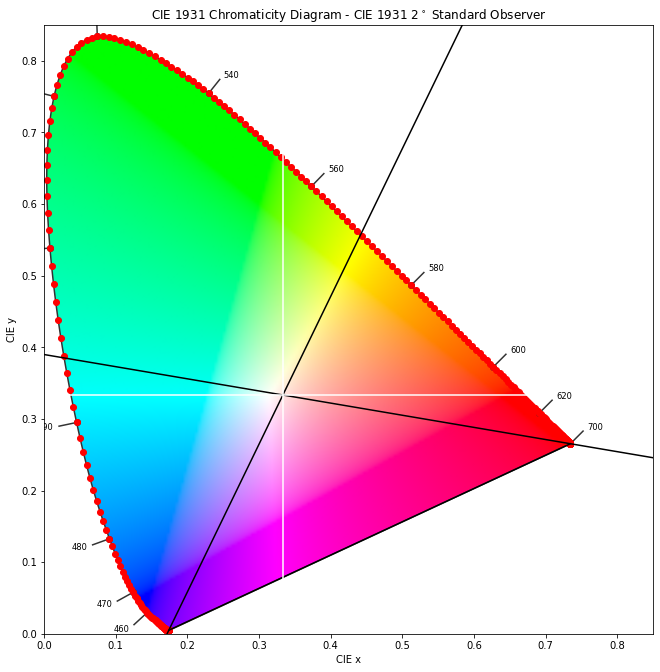

In [ ]:
a = 380
b = 700
c = 1

TLs = np.linspace(a,b,(((int(b)-int(a))*c)+1))
Tes = np.zeros((len(TLs),2))
for i in range(len(TLs)):
  Tes[i] = col.XYZ_to_xy(col.wavelength_to_XYZ(TLs[i]))
Tx = Tes[:,0]
Ty = Tes[:,1]

Tlx = np.linspace(0.4,0.5,c)
Tly = Slope380*Tlx + LinReg380[1]
Tline = np.zeros((len(Tlx),2))
Tline[:,0] = Tlx
Tline[:,1] = Tly

col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.plot(Tx,Ty,'ro')
xt = np.linspace(0,1,10)
xt2 = np.linspace(Point380[0],Point700[0],100*(10**1))
y1 = Slope380*xt + LinReg380[1]
y2 = Slope700*xt + LinReg700[1]
y3 = SlopeBot*xt2 + InterBot
p.plot(xt,y1,color='k')
p.plot(xt,y2,color='k')
p.plot(xt2,y3,'k-')
p.axhline((1/3),color='w')
p.axvline((1/3),color='w')
p.axis([0.0,0.85,0.0,0.85])
#p.axis([0.4,0.5,0.5,0.6])
#p.plot(Tline[417,0],Tline[417,1],'ro')

In [ ]:
T1 = [(1/3),(1/3)]
T2 = [0.2,(1/3)]
T3 = [0.4,(1/3)]
T4 = [(1/3),0.2]
T5 = [(1/3),0.4]
T6 = [0.2,0.2]
T7 = [0.2,0.5]
T8 = [0.4,0.5]
T9 = [0.5,0.4]
T10 = [0.5,0.2]
T11 = [0.3,0.1]

Debug = ColorQuality(T10,0.01)
print(Debug)

The point you have given has a dominant wavelength that does not exist.
(nan, 502.43154526315789, 0.82593937996924682)


##Testing Gaussian and Color Matching Functions

###Poster

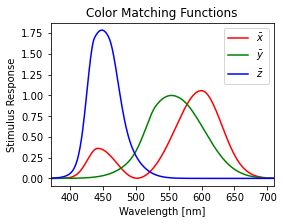

In [ ]:
N = 1000
xs = np.linspace(0,N,N+1)
fig,ax = p.subplots(1,1,figsize=(4,3))
ax.plot(xs,xbar(xs),'r-',label='$\\bar{x}$')
ax.plot(xs,ybar(xs),'g-',label='$\\bar{y}$')
ax.plot(xs,zbar(xs),'b-',label='$\\bar{z}$')
ax.set_xlim(370,710)
ax.set_title('Color Matching Functions')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Stimulus Response')
ax.legend()

In [ ]:
#N = 1000
#xs = np.linspace(0,N,N+1)
#col.plotting.plot_single_cmfs(standalone=False)
#fig = p.gcf()
#fig.set_size_inches(10,10)
#p.plot(xs,xbar(xs),'m-')
#p.plot(xs,ybar(xs),'y-')
#p.plot(xs,zbar(xs),'c-')

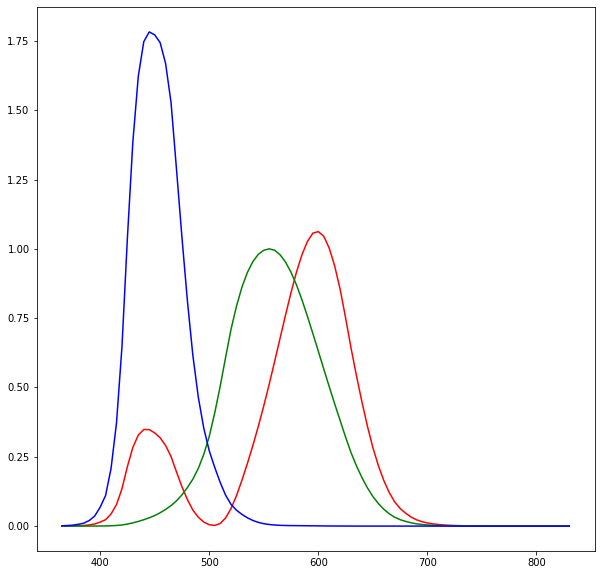

In [ ]:
CIESO = pd.read_csv('/CIESO.csv')
CIESO = np.array(CIESO)
SOL = CIESO[:,0]
SOxb = CIESO[:,1]
SOyb = CIESO[:,2]
SOzb = CIESO[:,3]

fig,ax = p.subplots(1,1,figsize=(10,10))
ax.plot(SOL,SOxb,color='r')
ax.plot(SOL,SOyb,color='g')
ax.plot(SOL,SOzb,color='b')

#col.plotting.plot_single_cmfs(standalone=False)
#fig = p.gcf()
#fig.set_size_inches(10,10)
#p.plot(SOL,SOxb,color='m')
#p.plot(SOL,SOyb,color='y')
#p.plot(SOL,SOzb,color='c')

##Data Processing

In [ ]:
#Import data
name = 'Spectral.dat'
data = pd.read_table('/'+name)
data = np.array(data)

lambdas = np.zeros(len(data))
P05 = np.zeros(len(data))
P1 = np.zeros(len(data))
P2 = np.zeros(len(data))
P4 = np.zeros(len(data))
P6 = np.zeros(len(data))
lambdas = data[:,0]
P05 = data[:,1]
P1 = data[:,2]
P2 = data[:,3]
P4 = data[:,4]
P6 = data[:,5]

def clean(list):
  for i in range(len(list)):
    if list[i] == '--':
      #print(i)
      list[i] = 0.0
  return np.array(list,dtype='float64')

P05 = clean(P05)
P1 = clean(P1)
P2 = clean(P2)
P4 = clean(P4)
P6 = clean(P6)

#print('Color coordinates using requested data:')
#print('Color Map coordinates for 0.5%: '+str(ColorCoord(lambdas,P05)[0])+', '+str(ColorCoord(lambdas,P05)[1]))
#print('Color Map coordinates for 1%:   '+str(ColorCoord(lambdas,P1)[0])+', '+str(ColorCoord(lambdas,P1)[1]))
#print('Color Map coordinates for 2%:   '+str(ColorCoord(lambdas,P2)[0])+', '+str(ColorCoord(lambdas,P2)[1]))
#print('Color Map coordinates for 4%:   '+str(ColorCoord(lambdas,P4)[0])+', '+str(ColorCoord(lambdas,P4)[1]))
#print('Color Map coordinates for 6%:   '+str(ColorCoord(lambdas,P6)[0])+', '+str(ColorCoord(lambdas,P6)[1]))
#print(' ')
#print('Color coordinates using better data:')

#0.5%
data5 = pd.read_table('/P05.dat')
spd05 = col.SpectralPowerDistribution(data5)
data5 = np.array(data5)
lam5 = data5[:,0]
spec5 = data5[:,1]
lam5,spec5 = clean(lam5),clean(spec5)

spec5[2920] = spec5[2919]
spec5[817] = spec5[816]
spec5[833] = spec5[832]
spec5[834] = spec5[832]
spec5[835] = spec5[832]
spec5[836] = spec5[832]
spec5[837] = spec5[832]
spec5[838] = spec5[832]
spec5[839] = spec5[832]
spec5[2200:2240] = spec5[2199]

#print('Color Map coordinates for 0.5%:                  '+str(ColorCoord(lam5,spec5)[0])+', '+str(ColorCoord(lam5,spec5)[1]))
#fig3,ax3 = p.subplots(1,1)
#ax3.plot(lam5,spec5,'b')
#ax3.set_xlim(9070,9080)

#1%
data1 = pd.read_table('/P1.dat')
data1 = np.array(data1)
lam1 = data1[:,0]
spec1 = data1[:,1]
lam1,spec1 = clean(lam1),clean(spec1)

#fig,ax = p.subplots(1,1)
#ax.plot(lam1,spec1)
#ax.set_title('Raw Data')
#print('Color Map coordinates for 1% raw dataset:        '+str(ColorCoord(lam1,spec1)[0])+', '+str(ColorCoord(lam1,spec1)[1]))

filler1 = np.linspace(spec1[2155],spec1[2304],(2304-2155))
spec1[2155:2304] = filler1
#fig2,ax2 = p.subplots(1,1)
#ax2.plot(lam1,spec1)
#ax2.set_title('One Peak Removed')
#print('Color Map coordinates for 1% one peak removed:   '+str(ColorCoord(lam1,spec1)[0])+', '+str(ColorCoord(lam1,spec1)[1]))

filler2 = np.linspace(spec1[793],spec1[854],(854-793))
spec1[793:854] = filler2
#fig3,ax3 = p.subplots(1,1)
#ax3.plot(lam1,spec1)
#ax3.set_title('Two Peaks Removed')
#print('Color Map coordinates for 1% two peaks removed:  '+str(ColorCoord(lam1,spec1)[0])+', '+str(ColorCoord(lam1,spec1)[1]))

#2%
data2 = pd.read_table('/P2.dat')
data2 = np.array(data2)
lam2 = data2[:,0]
spec2 = data2[:,1]
lam2,spec2 = clean(lam2),clean(spec2)

filler3 = np.linspace(spec2[2169],spec2[2261],(2261-2169))
spec2[2169:2261] = filler3
spec2[1487] = spec2[1486]
#fig3,ax3 = p.subplots(1,1)
#ax3.plot(lam2,spec2)

#4%
data4 = pd.read_table('/P4.dat')
data4 = np.array(data4)
lam4 = data4[:,0]
spec4 = data4[:,1]
lam4,spec4 = clean(lam4),clean(spec4)

filler4 = np.linspace(spec4[823],spec4[849],(849-823))
spec4[823:849] = filler4
#fig3,ax3 = p.subplots(1,1)
#ax3.plot(lam4,spec4)

#filler5 = np.linspace(spec4[2165],spec4[2256],(2256-2165))
filler5 = gauss(lam4[2164:2255],13000,775.0,18.0,5.0)
spec4[2164:2255] = filler5
#fig3,ax3 = p.subplots(1,1)
#ax3.plot(lam4,spec4)
#test = np.linspace(0,10000,10001)
#test2 = gauss(test,00000,7750,180,50)
#ax3.plot(test,test2,'ro')
#ax3.set_xlim(7000,8000)

#6%
data6 = pd.read_table('/P6.dat')
data6 = np.array(data6)
lam6 = data6[:,0]
spec6 = data6[:,1]
lam6,spec6 = clean(lam6),clean(spec6)

spec6[828:841] = spec6[825]
spec6[2015:2300] = np.linspace(((spec6[2015]+spec6[2015])/2),spec6[2300],(2300-2015))

#fig3,ax3 = p.subplots(1,1)
#ax3.plot(lam6,spec6,'m')
#print('Color Map coordinates for 6%:                    '+str(ColorCoord(lam6,spec6)[0])+', '+str(ColorCoord(lam6,spec6)[1]))

#OLED
dataO = pd.read_table('/OLED.dat')
dataO = np.array(dataO)
lamO = dataO[:,0]
specO = dataO[:,1]
lamO,specO = clean(lamO),clean(specO)

#Sun
dataSun = pd.read_table('/Sun.dat')
dataSun = np.array(dataSun)
lamSun = dataSun[:,0]
specSun = dataSun[:,1]
lamSun,specSun = clean(lamSun),clean(specSun)

###Poster

Text(700, 3.0, '$y=\\frac{Y}{X+Y+Z}$')

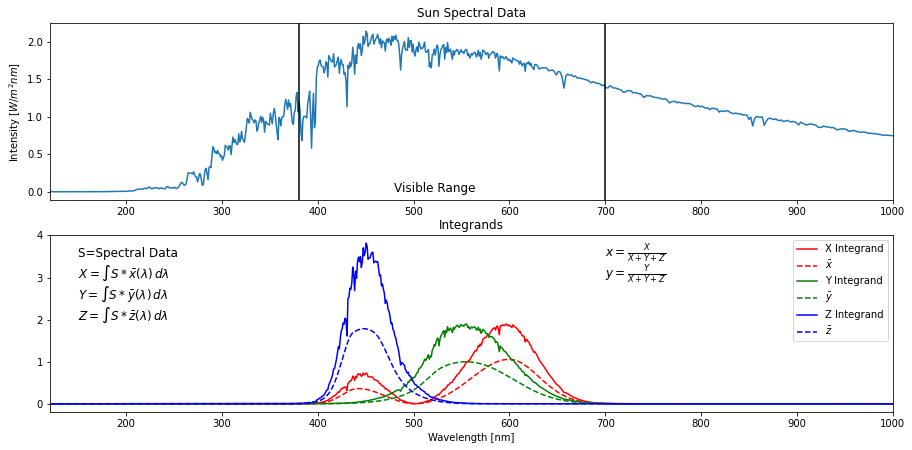

In [ ]:
xbarsun = specSun * xbar(lamSun)
ybarsun = specSun * ybar(lamSun)
zbarsun = specSun * zbar(lamSun)

fig,(ax,ax2) = p.subplots(2,1,figsize=(15.1,7.15))
ax.plot(lamSun,specSun)
ax.set_title('Sun Spectral Data')
ax.set_ylabel('Intensity [$W/m^2nm$]')
ax.set_xlim(lamSun[0],1000)
ax.axvline(380,color='k')
ax.axvline(700,color='k')
ax.annotate('Visible Range',(480,0),size=12)
ax2.set_title('Integrands')
ax2.set_xlabel('Wavelength [nm]')
ax2.set_xlim(lamSun[0],1000)
ax2.plot(lamSun,xbarsun,'r-',label='X Integrand')
ax2.plot(lamSun,xbar(lamSun),'r--',label='$\\bar{x}$')
ax2.plot(lamSun,ybarsun,'g-',label='Y Integrand')
ax2.plot(lamSun,ybar(lamSun),'g--',label='$\\bar{y}$')
ax2.plot(lamSun,zbarsun,'b-',label='Z Integrand')
ax2.plot(lamSun,zbar(lamSun),'b--',label='$\\bar{z}$')
ax2.legend()
ax2.annotate('S=Spectral Data',(150,3.5),size=12)
ax2.annotate('$X=\int S*\\bar{x}(\lambda)\,d\lambda$',(150,3.0),size=12)
ax2.annotate('$Y=\int S*\\bar{y}(\lambda)\,d\lambda$',(150,2.5),size=12)
ax2.annotate('$Z=\int S*\\bar{z}(\lambda)\,d\lambda$',(150,2.0),size=12)
ax2.annotate('$x=\\frac{X}{X+Y+Z}$',(700,3.5),size=12)
ax2.annotate('$y=\\frac{Y}{X+Y+Z}$',(700,3.0),size=12)

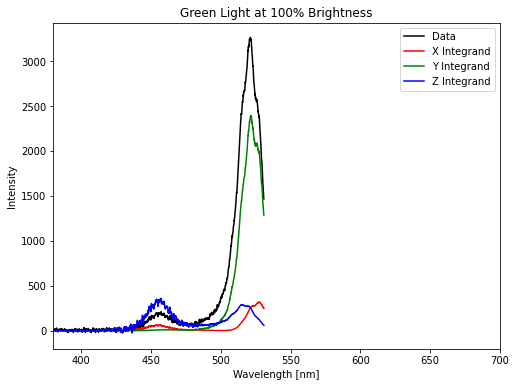

In [ ]:
xbarG = specG100 * xbar(lamG100)
ybarG = specG100 * ybar(lamG100)
zbarG = specG100 * zbar(lamG100)

fig,ax = p.subplots(1,1,figsize=(8,6))
ax.plot(lamG100,specG100,'k-',label='Data')
ax.set_title('Green Light at 100% Brightness')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Intensity')
ax.set_xlim(380,700)
ax.plot(lamG100,xbarG,'r-',label='X Integrand')
ax.plot(lamG100,ybarG,'g-',label='Y Integrand')
ax.plot(lamG100,zbarG,'b-',label='Z Integrand')
ax.legend()

#Color Map

##Creating the Boundary of the Color map

In [ ]:
#Boundary
#b = 441
#r = 640
#b = 380
#r = 700
#bl = np.linspace(b,r,((r-b)+1))
#bs = np.zeros_like(bl)
#bound = np.zeros((len(bs),2))
#for i in range(len(bl)):
#  bs[i] = 1.0
#  fs = ColorCoord(bl,bs)
#  bound[i] = fs[0],fs[1]
#  bs[i] = 0.0
#bx = bound[:,0]
#by = bound[:,1]

In [ ]:
##Boundary Try 2
#BoundLams = np.linspace(300,750,((750-300)+1))
#BoundSpec = np.zeros_like(BoundLams)
#HR = (700-380)+1
#Boundary = np.zeros((HR,2))
#for i in range(80,401):
#  BoundSpec[i] = 10.0
#  spdB = col.SpectralPowerDistribution(BoundSpec,BoundLams)
#  XYZB = col.colorimetry.spectral_to_XYZ_integration(spdB)
#  bv = col.XYZ_to_xy(XYZB)
#  Boundary[i-80] = bv[0],bv[1]
#  BoundSpec[i] = 0.0

#Bx = Boundary[:,0]
#By = Boundary[:,1]

#fig,ax = p.subplots(1,1,figsize=(10,10))
#ax.set_xlim(0.0,0.85)
#ax.set_ylim(0.0,0.85)
#ax.plot(Bx,By,'k-')
#ax.plot([Bx[0],Bx[-1]],[By[0],By[-1]],'k-')

#col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
#fig = p.gcf()
#fig.set_size_inches(10,10)
#p.plot(Bx,By,'ro')
#p.plot([Bx[0],Bx[-1]],[By[0],By[-1]],'ro')

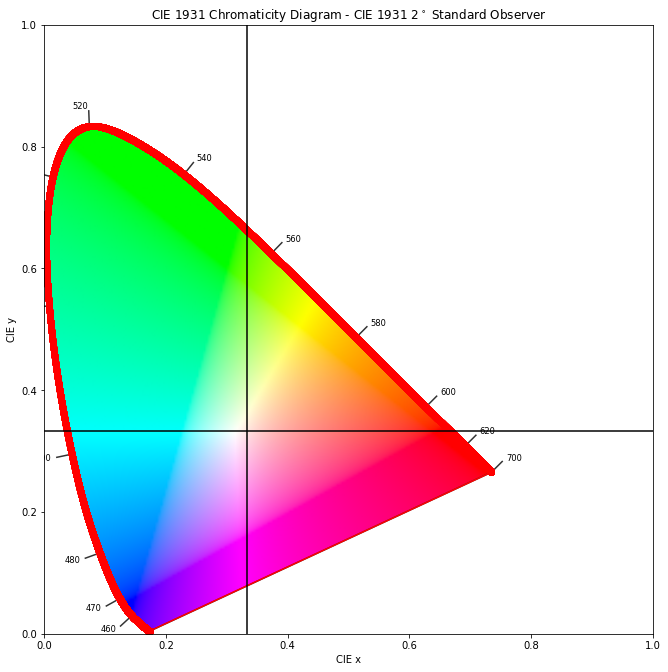

In [ ]:
#Boundary try 3
Scale = 100
Bls = np.linspace(380,700,(((700-380)*Scale)+1))
Boundary = np.zeros((len(Bls),2))
for i in range(len(Bls)):
  Boundary[i] = col.XYZ_to_xy(col.wavelength_to_XYZ(Bls[i]))

Bx = Boundary[:,0]
By = Boundary[:,1]

col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.plot(Bx,By,'ro')
p.plot([Bx[0],Bx[-1]],[By[0],By[-1]],'r-')
p.axhline((1/3),color='k')
p.axvline((1/3),color='k')

##Brightness

828811.518072 828811518.072


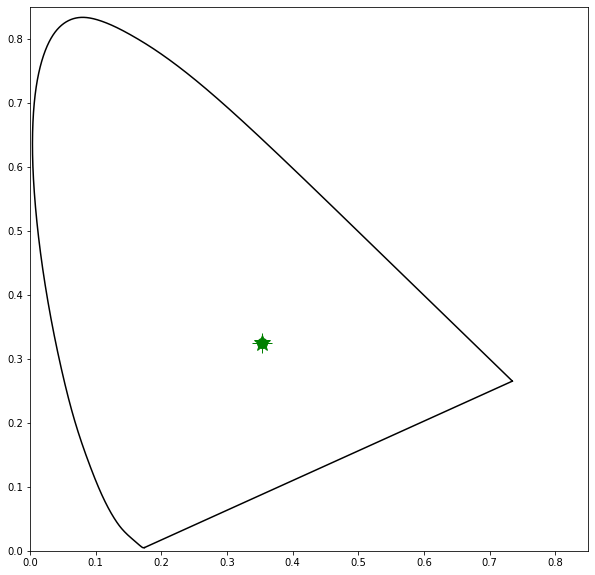

In [ ]:
fig4,ax4 = p.subplots(1,1,figsize=(10,10))
ax4.plot(ColorCoord(lam1,spec1)[0],ColorCoord(lam1,spec1)[1],'g*',markersize=17)
ax4.plot((0.35259),(0.3253),'go',markersize=10) #1
#Brightness?
ax4.plot(ColorCoord(lam1,(spec1*1000))[0],ColorCoord(lam1,(spec1*1000))[1],'g+',markersize=20)
print(ColorCoord(lam1,(spec1))[3],ColorCoord(lam1,(spec1*1000))[3])
#Settings
ax4.set_xlim(0.0,0.85)
ax4.set_ylim(0.0,0.85)
#Boundary
ax4.plot(Bx,By,'k-')
ax4.plot([Bx[0],Bx[-1]],[By[0],By[-1]],'k-')

##Sample Data

NameError: ignored

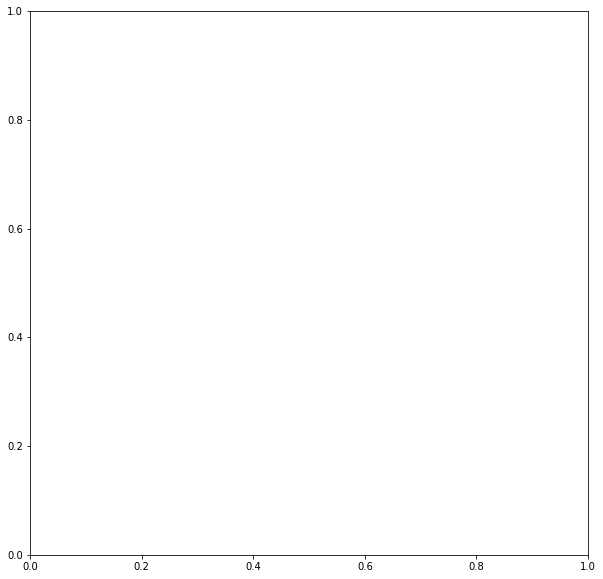

In [ ]:
#Plot x-y
fig4,ax4 = p.subplots(1,1,figsize=(10,10))
#ax4.plot(ColorCoord(lambdas,P05)[0],ColorCoord(lambdas,P05)[1],'b*',markersize=10)
#ax4.plot(ColorCoord(lambdas,P1)[0],ColorCoord(lambdas,P1)[1],'g*',markersize=10)
#ax4.plot(ColorCoord(lambdas,P2)[0],ColorCoord(lambdas,P2)[1],'r*',markersize=10)
#ax4.plot(ColorCoord(lambdas,P4)[0],ColorCoord(lambdas,P4)[1],'c*',markersize=10)
#ax4.plot(ColorCoord(lambdas,P6)[0],ColorCoord(lambdas,P6)[1],'m*',markersize=10)
#Better Data
ax4.plot(ColorCoord(lam5,spec5)[0],ColorCoord(lam5,spec5)[1],'b*',markersize=17)
ax4.plot(ColorCoord(lam1,spec1)[0],ColorCoord(lam1,spec1)[1],'g*',markersize=17)
ax4.plot(ColorCoord(lam2,spec2)[0],ColorCoord(lam2,spec2)[1],'r*',markersize=17)
ax4.plot(ColorCoord(lam4,spec4)[0],ColorCoord(lam4,spec4)[1],'c*',markersize=17)
ax4.plot(ColorCoord(lam6,spec6)[0],ColorCoord(lam6,spec6)[1],'m*',markersize=17)
ax4.plot(ColorCoord(lamO,specO)[0],ColorCoord(lamO,specO)[1],'k*',markersize=17)
#Data from paper
ax4.plot((0.46574),(0.35349),'bo',markersize=10) #0.5
ax4.plot((0.35259),(0.3253),'go',markersize=10) #1
ax4.plot((0.56057),(0.3691),'ro',markersize=10) #2
ax4.plot((0.52328),(0.36855),'co',markersize=10) #4
ax4.plot((0.62086),(0.3445),'mo',markersize=10) #6
ax4.plot((0.29168),(0.62151),'ko',markersize=10) #OLED
#Settings
ax4.set_xlim(0.0,0.85)
ax4.set_ylim(0.0,0.85)
#ax4.set_xlim(0.1,0.2)
#ax4.set_ylim(0.0,0.05)
#ax4.set_xlim(0.6,0.8)
#ax4.set_ylim(0.25,0.35)
#Boundary
ax4.plot(Bx,By,'k-')
ax4.plot([Bx[0],Bx[-1]],[By[0],By[-1]],'k-')

##Using Colour package

###Poster

(-0.050000000000000003, 0.84999999999999998, 0.0, 0.90000000000000002)

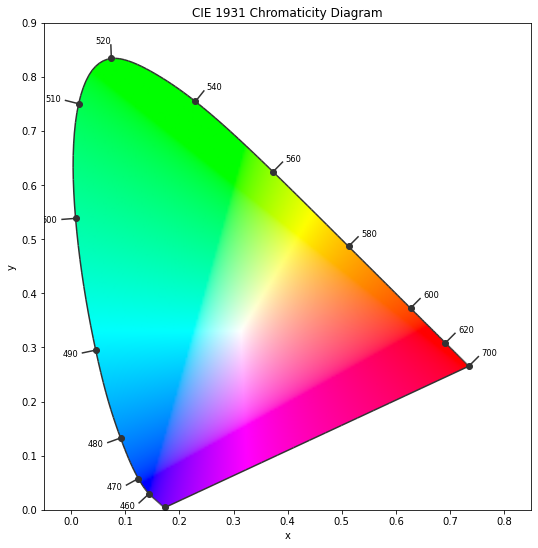

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(8,8)
p.title('CIE 1931 Chromaticity Diagram')
p.xlabel('x')
p.ylabel('y')
p.axis([-0.05,0.85,0.0,0.90])

#p.title('Sun Data Point')
#p.plot(xySun[0],xySun[1],'ko')
#p.annotate('Sun',xySun+0.01,size=20)

In [ ]:
CQE1 = ColorQuality([0.2,0.2],0.001)
CQE2 = ColorQuality([0.2,0.6],0.001)

print(CQE1[0:2])
print(CQE2[0],CQE2[2])

The point you have given has a complementary wavelength that does not exist.
(476.98668323008849, 578.05448078625955)
521.13304 0.532627543586


Text(0.45, 0.85, 'Color Purity = $\\frac{A}{B}$')

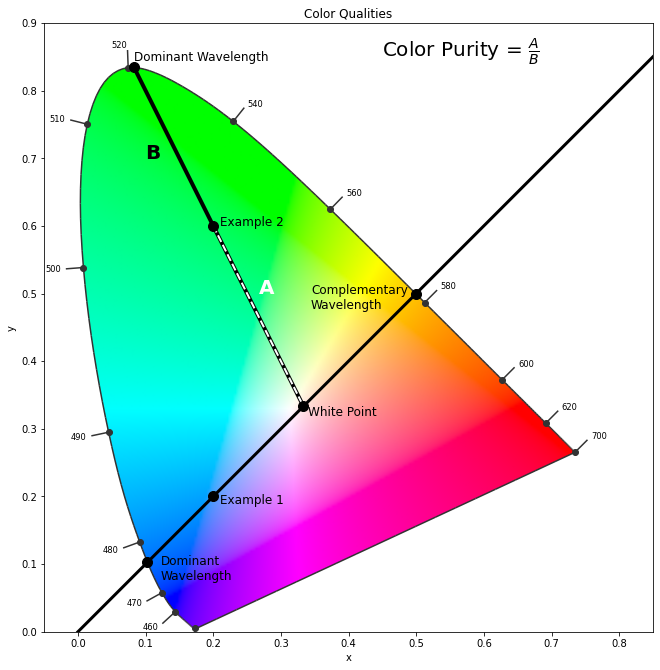

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('Color Qualities')
p.xlabel('x')
p.ylabel('y')
p.axis([-0.05,0.85,0.0,0.90])

#
E1D = col.XYZ_to_xy(col.wavelength_to_XYZ(CQE1[0]))
E1C = col.XYZ_to_xy(col.wavelength_to_XYZ(CQE1[1]))
E2D = col.XYZ_to_xy(col.wavelength_to_XYZ(CQE2[0]))

E2LinReg = linreg([0.2,WhitePoint[0]],[0.6,WhitePoint[1]])

E1Line = np.linspace(0,0.9,1000)
Xa = np.linspace(0.2,(1/3),1000)
E2LineA = E2LinReg[0]*Xa + E2LinReg[1]
Xb = np.linspace(E2D[0],(1/3),1000)
E2LineB = E2LinReg[0]*Xb + E2LinReg[1]

#
p.plot(E1Line,E1Line,'k-',lw=3)
p.plot(Xb,E2LineB,'k-',lw=4,label='B')
p.plot(Xa,E2LineA,'w--',lw=2,label='A')

#
p.plot((1/3),(1/3),'ko',markersize=10)
p.plot(0.2,0.2,'ko',markersize=10)
p.plot(0.2,0.6,'ko',markersize=10)
p.plot(E1D[0],E1D[1],'ko',markersize=10)
p.plot(E1C[0],E1C[1],'ko',markersize=10)
p.plot(E2D[0],E2D[1],'ko',markersize=10)

#
p.annotate('White Point',(0.34,0.32),size=12)
p.annotate('Example 1',(0.21,0.19),size=12)
p.annotate('Example 2',(0.21,0.6),size=12)
p.annotate('Dominant\nWavelength',(E1D[0]+0.02,E1D[1]-0.025),size=12)
p.annotate('Complementary\nWavelength',(E1C[0]-0.155,E1C[1]-0.022),size=12)
p.annotate('Dominant Wavelength',(E2D[0],E2D[1]+0.01),size=12)
p.annotate('A',(0.267,0.5),size=20,color='w',fontweight='bold')
p.annotate('B',(0.1,0.7),size=20,fontweight='bold')

p.annotate('Color Purity = $\\frac{A}{B}$',(0.45,0.85),size=20)

Text(0.08, 0.22, 'Example')

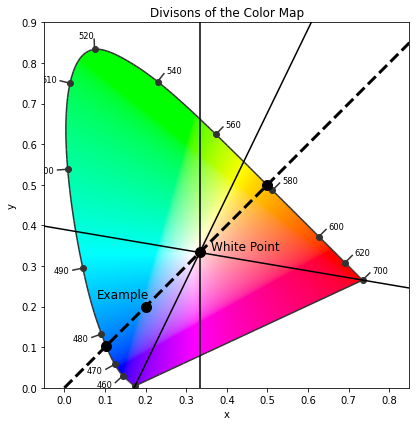

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(6,6)
p.title('Divisons of the Color Map')
p.xlabel('x')
p.ylabel('y')
p.axis([-0.05,0.85,0.0,0.90])

Xpap = np.linspace(-0.05,1,1000)
L1 = Slope380*Xpap + LinReg380[1]
L2 = Slope700*Xpap + LinReg700[1]

p.plot((1/3),(1/3),'ko',markersize=10)
p.plot(Xpap,L1,'k-')
p.plot(Xpap,L2,'k-')
p.axvline(1/3,color='k')
p.plot(0.2,0.2,'ko',markersize=10)
p.plot(E1Line,E1Line,'k--',lw=3)
p.plot(E1D[0],E1D[1],'ko',markersize=10)
p.plot(E1C[0],E1C[1],'ko',markersize=10)

p.annotate('White Point',(0.36,0.34),size=12)
p.annotate('Example',(0.08,0.22),size=12)

###Not Poster

(0.0, 0.84999999999999998, 0.0, 0.84999999999999998)

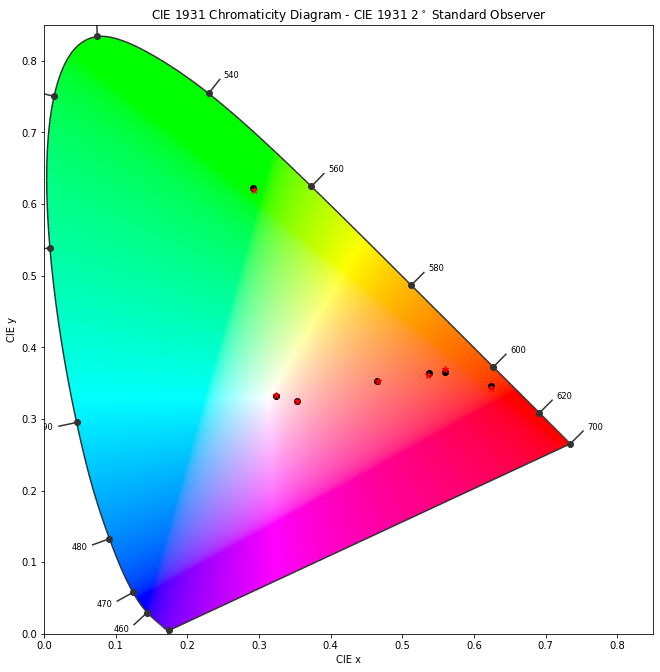

In [ ]:
spd05 = col.SpectralPowerDistribution(spec5,lam5)
XYZ05 = col.colorimetry.spectral_to_XYZ_integration(spd05)
xy05 = col.XYZ_to_xy(XYZ05)

spd1 = col.SpectralPowerDistribution(spec1,lam1)
XYZ1 = col.colorimetry.spectral_to_XYZ_integration(spd1)
xy1 = col.XYZ_to_xy(XYZ1)

spd2 = col.SpectralPowerDistribution(spec2,lam2)
XYZ2 = col.colorimetry.spectral_to_XYZ_integration(spd2)
xy2 = col.XYZ_to_xy(XYZ2)

spd4 = col.SpectralPowerDistribution(spec4,lam4)
XYZ4 = col.colorimetry.spectral_to_XYZ_integration(spd4)
xy4 = col.XYZ_to_xy(XYZ4)

spd6 = col.SpectralPowerDistribution(spec6,lam6)
XYZ6 = col.colorimetry.spectral_to_XYZ_integration(spd6)
xy6 = col.XYZ_to_xy(XYZ6)

spdO = col.SpectralPowerDistribution(specO,lamO)
XYZO = col.colorimetry.spectral_to_XYZ_integration(spdO)
xyO = col.XYZ_to_xy(XYZO)

spdSun = col.SpectralPowerDistribution(specSun,lamSun)
XYZSun = col.colorimetry.spectral_to_XYZ_integration(spdSun)
xySun = col.XYZ_to_xy(XYZSun)

col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.plot(xy05[0],xy05[1],'ko')
p.plot(ColorCoord(lam5,spec5)[0],ColorCoord(lam5,spec5)[1],'r*',markersize=7)
p.plot(xy1[0],xy1[1],'ko')
p.plot(ColorCoord(lam1,spec1)[0],ColorCoord(lam1,spec1)[1],'r*',markersize=7)
p.plot(xy2[0],xy2[1],'ko')
p.plot(ColorCoord(lam2,spec2)[0],ColorCoord(lam2,spec2)[1],'r*',markersize=7)
p.plot(xy4[0],xy4[1],'ko')
p.plot(ColorCoord(lam4,spec4)[0],ColorCoord(lam4,spec4)[1],'r*',markersize=7)
p.plot(xy6[0],xy6[1],'ko')
p.plot(ColorCoord(lam6,spec6)[0],ColorCoord(lam6,spec6)[1],'r*',markersize=7)
p.plot(xyO[0],xyO[1],'ko')
p.plot(ColorCoord(lamO,specO)[0],ColorCoord(lamO,specO)[1],'r*',markersize=7)
p.plot(xySun[0],xySun[1],'ko')
p.plot(ColorCoord(lamSun,specSun)[0],ColorCoord(lamSun,specSun)[1],'r*',markersize=7)
#p.annotate('1%',xy=(0,0),xytext=(0.37,0.42),fontsize=14)
p.axis([0.0,0.85,0.0,0.85])

#Temperature

##Wein's Law

3756.997218980941


Text(0.5, 1.0, 'Wavelength and Value of Maximum Intensity')

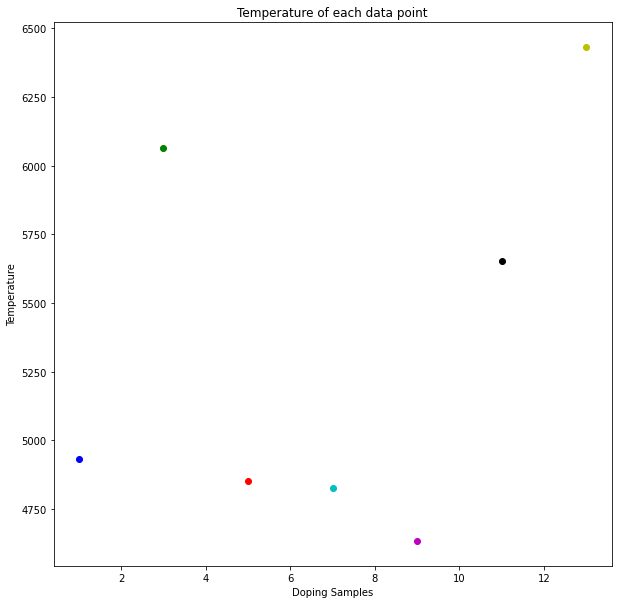

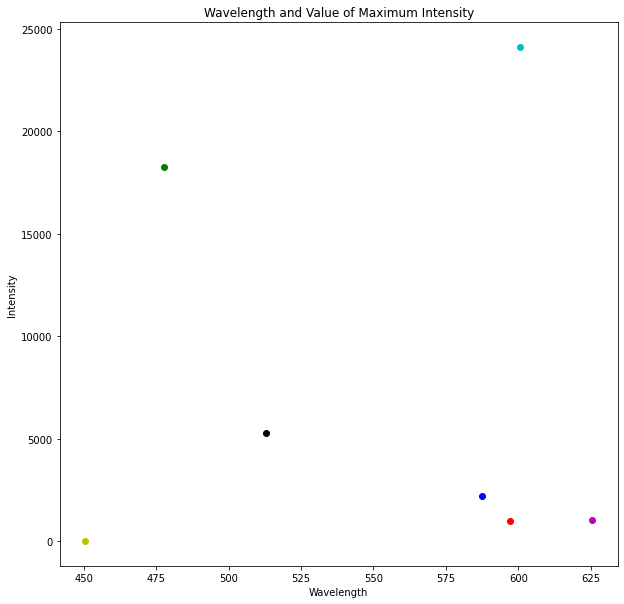

In [ ]:
def GetTemp(lam_list,spec_list):
  ind = np.argmax(spec_list)
  lamb = lam_list[ind]
  sp = spec_list[ind]
  T = (2.897771955*(10**(-3)))/(lamb*(10**(-9)))
  return T,lamb,sp

print(GetTemp([771.3],[100])[0])

T05 = GetTemp(lam5,spec5)[0]
T1 = GetTemp(lam1,spec1)[0]
T2 = GetTemp(lam2,spec2)[0]
T4 = GetTemp(lam4,spec4)[0]
T6 = GetTemp(lam6,spec6)[0]
TO = GetTemp(lamO,specO)[0]
TSun = GetTemp(lamSun,specSun)[0]

fig5,ax5 = p.subplots(1,1,figsize=(10,10))
ax5.plot(1,T05,'bo')
ax5.plot(3,T1,'go')
ax5.plot(5,T2,'ro')
ax5.plot(7,T4,'co')
ax5.plot(9,T6,'mo')
ax5.plot(11,TO,'ko')
ax5.plot(13,TSun,'yo')
ax5.set_xlabel('Doping Samples')
ax5.set_ylabel('Temperature')
ax5.set_title('Temperature of each data point')

fig6,ax6 = p.subplots(1,1,figsize=(10,10))
ax6.plot(GetTemp(lam5,spec5)[1],GetTemp(lam5,spec5)[2],'bo')
ax6.plot(GetTemp(lam1,spec1)[1],GetTemp(lam1,spec1)[2],'go')
ax6.plot(GetTemp(lam2,spec2)[1],GetTemp(lam2,spec2)[2],'ro')
ax6.plot(GetTemp(lam4,spec4)[1],GetTemp(lam4,spec4)[2],'co')
ax6.plot(GetTemp(lam6,spec6)[1],GetTemp(lam6,spec6)[2],'mo')
ax6.plot(GetTemp(lamO,specO)[1],GetTemp(lamO,specO)[2],'ko')
ax6.plot(GetTemp(lamSun,specSun)[1],GetTemp(lamSun,specSun)[2],'yo')
ax6.set_xlabel('Wavelength')
ax6.set_ylabel('Intensity')
ax6.set_title('Wavelength and Value of Maximum Intensity')

##Using Colour Package

6432.34618202 6083.37423205


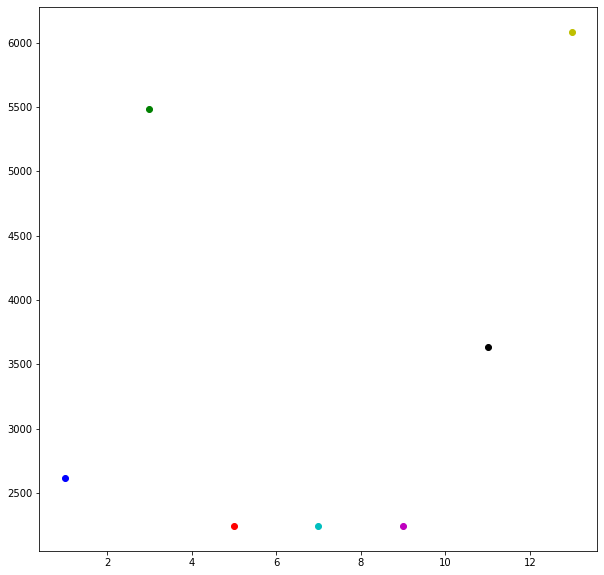

In [ ]:
TC05 = col.xy_to_CCT(xy05)
TC1 = col.xy_to_CCT(xy1)
TC2 = col.xy_to_CCT(xy2)
TC4 = col.xy_to_CCT(xy4)
TC6 = col.xy_to_CCT(xy6)
TCO = col.xy_to_CCT(xyO)
TCSun = col.xy_to_CCT(xySun)

print(TSun,TCSun)

fig7,ax7 = p.subplots(1,1,figsize=(10,10))
ax7.plot(1,TC05,'bo')
ax7.plot(3,TC1,'go')
ax7.plot(5,TC2,'ro')
ax7.plot(7,TC4,'co')
ax7.plot(9,TC6,'mo')
ax7.plot(11,TCO,'ko')
ax7.plot(13,TCSun,'yo')

##Temperature-Color Map

(0.49926231628318191, 0.41712352004631198)
(0.49926231637045165, 0.41712351973736655)
(0.49926231628318191, 0.41712352004631198)


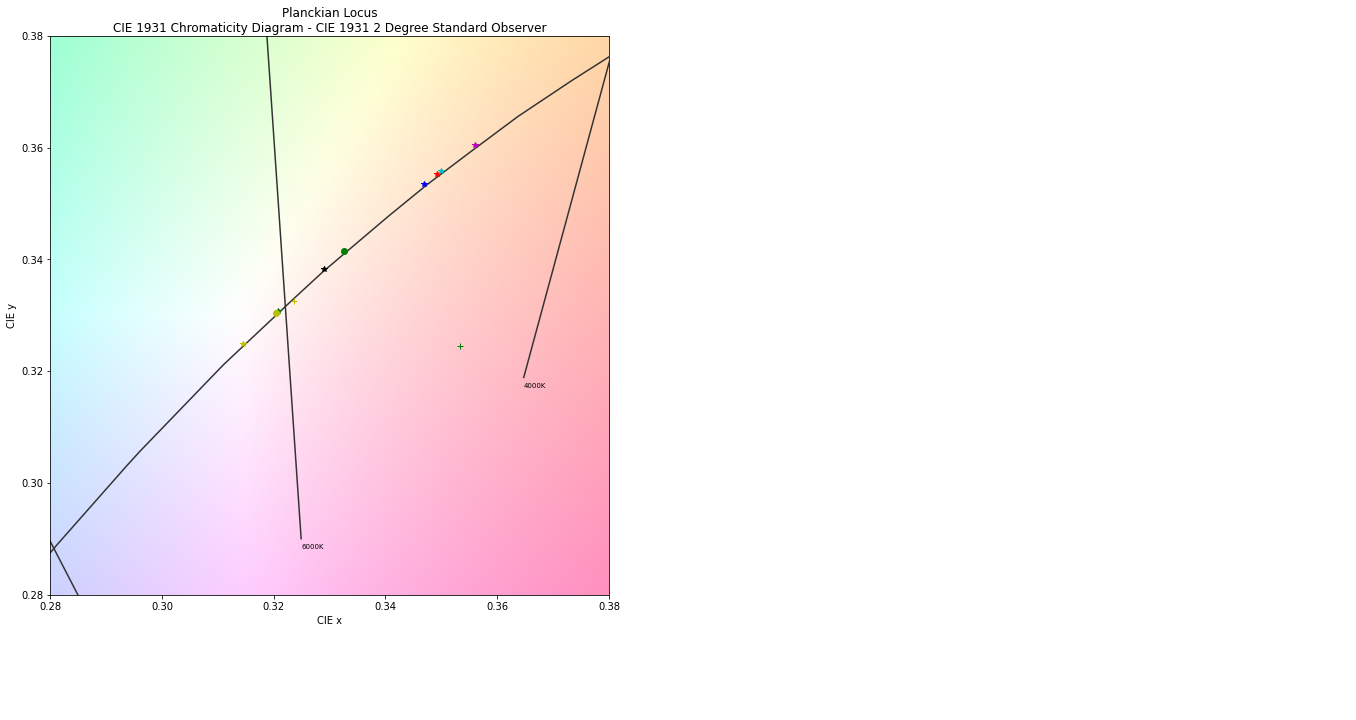

In [ ]:
def TempCoord(lam_list,Temp):
  hc = 1240
  c = (2.99792458)*(10**17)
  kb = (8.617333262145)*(10**(-5))
  c1 = 2*np.pi*hc*c
  c2 = hc/kb
  M = (c1/(lam_list**5))*(1/(np.exp(c2/(lam_list*Temp))-1))

  #Integrands
  IntX = xbar(lam_list)*M
  IntY = ybar(lam_list)*M
  IntZ = zbar(lam_list)*M

  #Integrate
  X = simps(IntX,lam_list)
  Y = simps(IntY,lam_list)
  Z = simps(IntZ,lam_list)

  #Coord
  x = X/(X + Y + Z)
  y = Y/(X + Y + Z)

  return x,y,X,Y,Z

TCord05 = TempCoord(lam5,T05)
xyTC05 = TCord05[0],TCord05[1]
TCCord05 = TempCoord(lam5,TC05)
xyTCC05 = TCCord05[0],TCCord05[1]

TCord1 = TempCoord(lam1,T1)
xyTC1 = TCord1[0],TCord1[1]
TCCord1 = TempCoord(lam1,TC1)
xyTCC1 = TCCord1[0],TCCord1[1]

TCord2 = TempCoord(lam2,T2)
xyTC2 = TCord2[0],TCord2[1]
TCCord2 = TempCoord(lam2,TC2)
xyTCC2 = TCCord2[0],TCCord2[1]

TCord4 = TempCoord(lam4,T4)
xyTC4 = TCord4[0],TCord4[1]
TCCord4 = TempCoord(lam4,TC4)
xyTCC4 = TCCord4[0],TCCord4[1]

TCord6 = TempCoord(lam6,T6)
xyTC6 = TCord6[0],TCord6[1]
TCCord6 = TempCoord(lam6,TC6)
xyTCC6 = TCCord6[0],TCCord6[1]

TCordO = TempCoord(lamO,TO)
xyTCO = TCordO[0],TCordO[1]
TCCordO = TempCoord(lamO,TCO)
xyTCCO = TCCordO[0],TCCordO[1]

TCordSun = TempCoord(lamSun,TSun)
xyTCSun = TCordSun[0],TCordSun[1]
TCCordSun = TempCoord(lamSun,TCSun)
xyTCCSun = TCCordSun[0],TCCordSun[1]

print(xyTCC2)
print(xyTCC4)
print(xyTCC6)

col.plotting.plot_planckian_locus_in_chromaticity_diagram_CIE1931([],standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
#p.axis([0.0,0.85,0.0,0.85])
p.axis([0.28,0.38,0.28,0.38])
#0.5%
p.plot(xyTC05[0],xyTC05[1],'b*')
p.plot(xyTCC05[0],xyTCC05[1],'bo')
p.plot(xy05[0],xy05[1],'b+')
#1%
p.plot(xyTC1[0],xyTC1[1],'g*')
p.plot(xyTCC1[0],xyTCC1[1],'go')
p.plot(xy1[0],xy1[1],'g+')
#2%
p.plot(xyTC2[0],xyTC2[1],'r*')
p.plot(xyTCC2[0],xyTCC2[1],'ro')
p.plot(xy2[0],xy2[1],'r+')
#4%
p.plot(xyTC4[0],xyTC4[1],'c*')
p.plot(xyTCC4[0],xyTCC4[1],'co')
p.plot(xy4[0],xy4[1],'c+')
#6%
p.plot(xyTC6[0],xyTC6[1],'m*')
p.plot(xyTCC6[0],xyTCC6[1],'mo')
p.plot(xy6[0],xy6[1],'m+')
#OLED
p.plot(xyTCO[0],xyTCO[1],'k*')
p.plot(xyTCCO[0],xyTCCO[1],'ko')
p.plot(xyO[0],xyO[1],'k+')
#Sun
#OLED
p.plot(xyTCSun[0],xyTCSun[1],'y*')
p.plot(xyTCCSun[0],xyTCCSun[1],'yo')
p.plot(xySun[0],xySun[1],'y+')

###Poster

(-0.050000000000000003, 0.84999999999999998, 0.0, 0.90000000000000002)

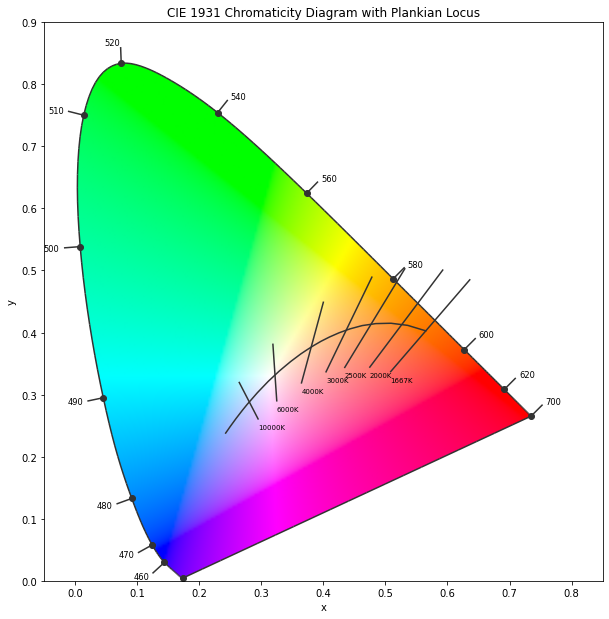

In [ ]:
col.plotting.plot_planckian_locus_in_chromaticity_diagram_CIE1931([],standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('CIE 1931 Chromaticity Diagram with Plankian Locus')
p.xlabel('x')
p.ylabel('y')
p.axis([-0.05,0.85,0.0,0.9])

#Our Data

##Calc all values

In [ ]:
##Blue
#50%
dataB50 = pd.read_table('/blue50.dat')
dataB50 = np.array(dataB50)
lamB50,specB50 = clean(dataB50[:,0]),clean(dataB50[:,1])

spdB50 = col.SpectralPowerDistribution(specB50,lamB50)
XYZB50 = col.colorimetry.spectral_to_XYZ_integration(spdB50)
xyB50 = col.XYZ_to_xy(XYZB50)

mxyB50 = ColorCoord(lamB50,specB50)

#75%
dataB75 = pd.read_table('/blue75.dat')
dataB75 = np.array(dataB75)
lamB75,specB75 = clean(dataB75[:,0]),clean(dataB75[:,1])

spdB75 = col.SpectralPowerDistribution(specB75,lamB75)
XYZB75 = col.colorimetry.spectral_to_XYZ_integration(spdB75)
xyB75 = col.XYZ_to_xy(XYZB75)

mxyB75 = ColorCoord(lamB75,specB75)

#100%
dataB100 = pd.read_table('/blue100.dat')
dataB100 = np.array(dataB100)
lamB100,specB100 = clean(dataB100[:,0]),clean(dataB100[:,1])

spdB100 = col.SpectralPowerDistribution(specB100,lamB100)
XYZB100 = col.colorimetry.spectral_to_XYZ_integration(spdB100)
xyB100 = col.XYZ_to_xy(XYZB100)

mxyB100 = ColorCoord(lamB100,specB100)


##Cyan
#50%
dataC50 = pd.read_table('/cyan50.dat')
dataC50 = np.array(dataC50)
lamC50,specC50 = clean(dataC50[:,0]),clean(dataC50[:,1])

spdC50 = col.SpectralPowerDistribution(specC50,lamC50)
XYZC50 = col.colorimetry.spectral_to_XYZ_integration(spdC50)
xyC50 = col.XYZ_to_xy(XYZC50)

mxyC50 = ColorCoord(lamC50,specC50)

#75%
dataC75 = pd.read_table('/cyan75.dat')
dataC75 = np.array(dataC75)
lamC75,specC75 = clean(dataC75[:,0]),clean(dataC75[:,1])

spdC75 = col.SpectralPowerDistribution(specC75,lamC75)
XYZC75 = col.colorimetry.spectral_to_XYZ_integration(spdC75)
xyC75 = col.XYZ_to_xy(XYZC75)

mxyC75 = ColorCoord(lamC75,specC75)

#100%
dataC100 = pd.read_table('/cyan100.dat')
dataC100 = np.array(dataC100)
lamC100,specC100 = clean(dataC100[:,0]),clean(dataC100[:,1])

spdC100 = col.SpectralPowerDistribution(specC100,lamC100)
XYZC100 = col.colorimetry.spectral_to_XYZ_integration(spdC100)
xyC100 = col.XYZ_to_xy(XYZC100)

mxyC100 = ColorCoord(lamC100,specC100)


##Green
#50%
dataG50 = pd.read_table('/green50.dat')
dataG50 = np.array(dataG50)
lamG50,specG50 = clean(dataG50[:,0]),clean(dataG50[:,1])

spdG50 = col.SpectralPowerDistribution(specG50,lamG50)
XYZG50 = col.colorimetry.spectral_to_XYZ_integration(spdG50)
xyG50 = col.XYZ_to_xy(XYZG50)

mxyG50 = ColorCoord(lamG50,specG50)

#75%
dataG75 = pd.read_table('/green75.dat')
dataG75 = np.array(dataG75)
lamG75,specG75 = clean(dataG75[:,0]),clean(dataG75[:,1])

spdG75 = col.SpectralPowerDistribution(specG75,lamG75)
XYZG75 = col.colorimetry.spectral_to_XYZ_integration(spdG75)
xyG75 = col.XYZ_to_xy(XYZG75)

mxyG75 = ColorCoord(lamG75,specG75)

#100%
dataG100 = pd.read_table('/green100.dat')
dataG100 = np.array(dataG100)
lamG100,specG100 = clean(dataG100[:,0]),clean(dataG100[:,1])

spdG100 = col.SpectralPowerDistribution(specG100,lamG100)
XYZG100 = col.colorimetry.spectral_to_XYZ_integration(spdG100)
xyG100 = col.XYZ_to_xy(XYZG100)

mxyG100 = ColorCoord(lamG100,specG100)


##Blue Light Filter Data
#Blue
dataFB = pd.read_table('/fblue.dat')
dataFB = np.array(dataFB)
lamFB,specFB = clean(dataFB[:,0]),clean(dataFB[:,1])

spdFB = col.SpectralPowerDistribution(specFB,lamFB)
XYZFB = col.colorimetry.spectral_to_XYZ_integration(spdFB)
xyFB = col.XYZ_to_xy(XYZFB)

mxyFB = ColorCoord(lamFB,specFB)

#Cyan
dataFC = pd.read_table('/fcyan.dat')
dataFC = np.array(dataFC)
lamFC,specFC = clean(dataFC[:,0]),clean(dataFC[:,1])

spdFC = col.SpectralPowerDistribution(specFC,lamFC)
XYZFC = col.colorimetry.spectral_to_XYZ_integration(spdFC)
xyFC = col.XYZ_to_xy(XYZFC)

mxyFC = ColorCoord(lamFC,specFC)

#Green
dataFG = pd.read_table('/fgreen.dat')
dataFG = np.array(dataFG)
lamFG,specFG = clean(dataFG[:,0]),clean(dataFG[:,1])

spdFG = col.SpectralPowerDistribution(specFG,lamFG)
XYZFG = col.colorimetry.spectral_to_XYZ_integration(spdFG)
xyFG = col.XYZ_to_xy(XYZFG)

mxyFG = ColorCoord(lamFG,specFG)

##Blue

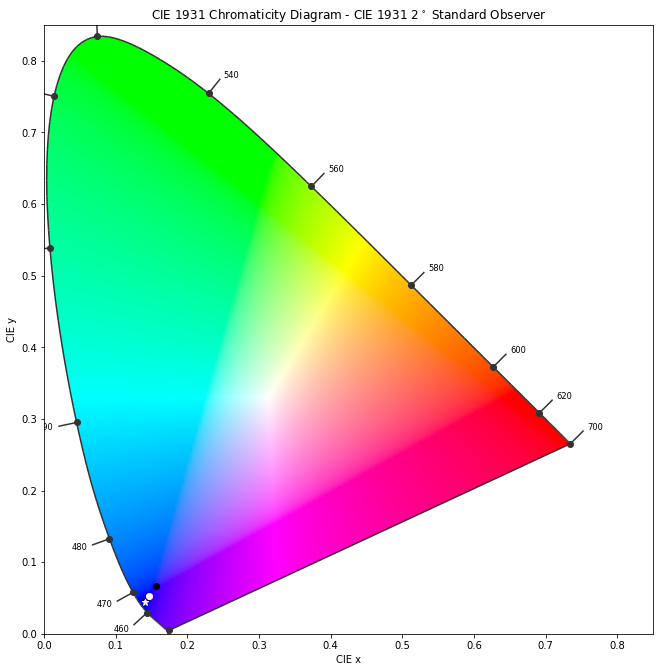

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.axis([0.0,0.85,0.0,0.85])
p.plot(xyB50[0],xyB50[1],'ko')
p.plot(xyB75[0],xyB75[1],'ro')
p.plot(xyB100[0],xyB100[1],'wo')
p.plot(mxyB50[0],mxyB50[1],'k*',markersize=7)
p.plot(mxyB75[0],mxyB75[1],'r*',markersize=7)
p.plot(mxyB100[0],mxyB100[1],'w*',markersize=7)

##Cyan

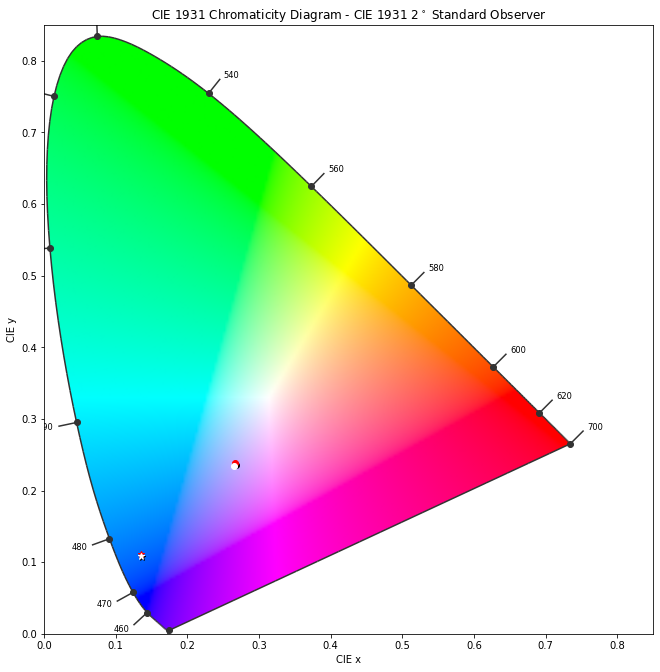

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.axis([0.0,0.85,0.0,0.85])
p.plot(xyC50[0],xyC50[1],'ko')
p.plot(xyC75[0],xyC75[1],'ro')
p.plot(xyC100[0],xyC100[1],'wo')
p.plot(mxyC50[0],mxyC50[1],'k*',markersize=7)
p.plot(mxyC75[0],mxyC75[1],'r*',markersize=7)
p.plot(mxyC100[0],mxyC100[1],'w*',markersize=7)

##Green

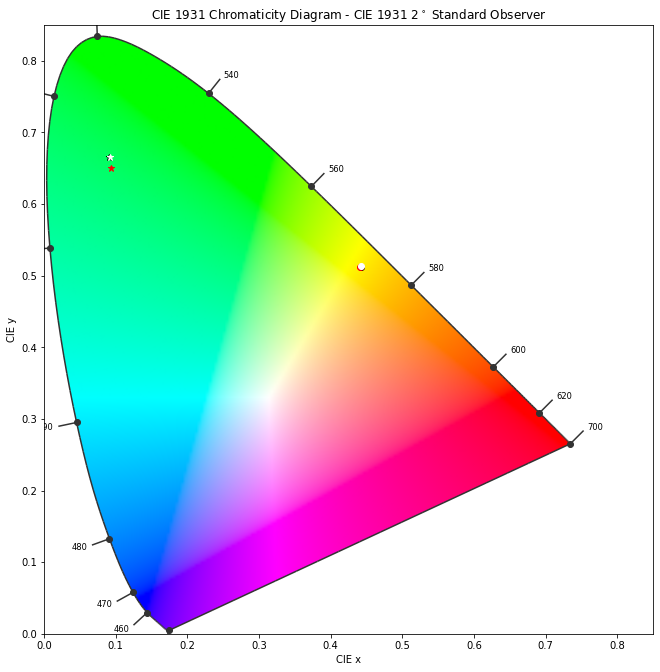

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.axis([0.0,0.85,0.0,0.85])
p.plot(xyG50[0],xyG50[1],'ko')
p.plot(xyG75[0],xyG75[1],'ro')
p.plot(xyG100[0],xyG100[1],'wo')
p.plot(mxyG50[0],mxyG50[1],'k*',markersize=7)
p.plot(mxyG75[0],mxyG75[1],'r*',markersize=7)
p.plot(mxyG100[0],mxyG100[1],'w*',markersize=7)

##Night Mode

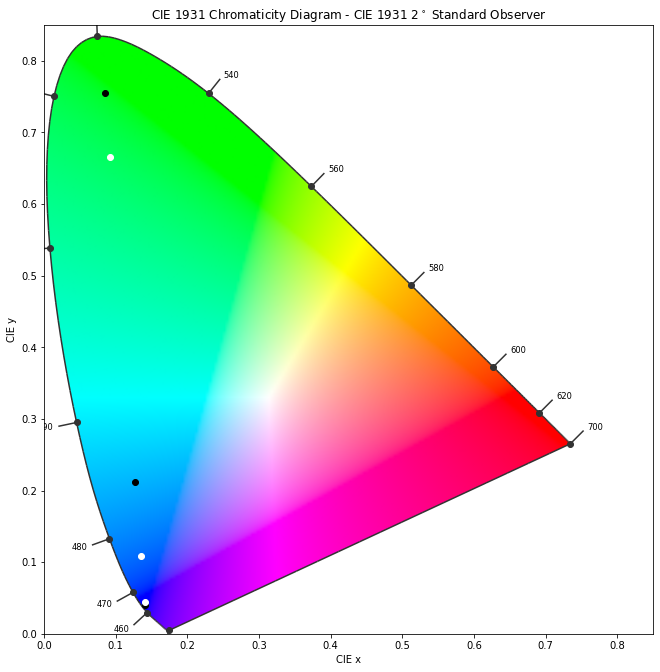

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.axis([0.0,0.85,0.0,0.85])
#p.plot(xyFB[0],xyFB[1],'ko')
#p.plot(xyFC[0],xyFC[1],'ko')
#p.plot(xyFG[0],xyFG[1],'ko')
#p.plot(xyB100[0],xyB100[1],'wo')
#p.plot(xyC100[0],xyC100[1],'wo')
#p.plot(xyG100[0],xyG100[1],'wo')
p.plot(mxyFB[0],mxyFB[1],'ko')
p.plot(mxyFC[0],mxyFC[1],'ko')
p.plot(mxyFG[0],mxyFG[1],'ko')
p.plot(mxyB100[0],mxyB100[1],'wo')
p.plot(mxyC100[0],mxyC100[1],'wo')
p.plot(mxyG100[0],mxyG100[1],'wo')

##Poster

##All Data

Text(0.0943966774404, 0.739586533143, 'Blue Light\nFilter')

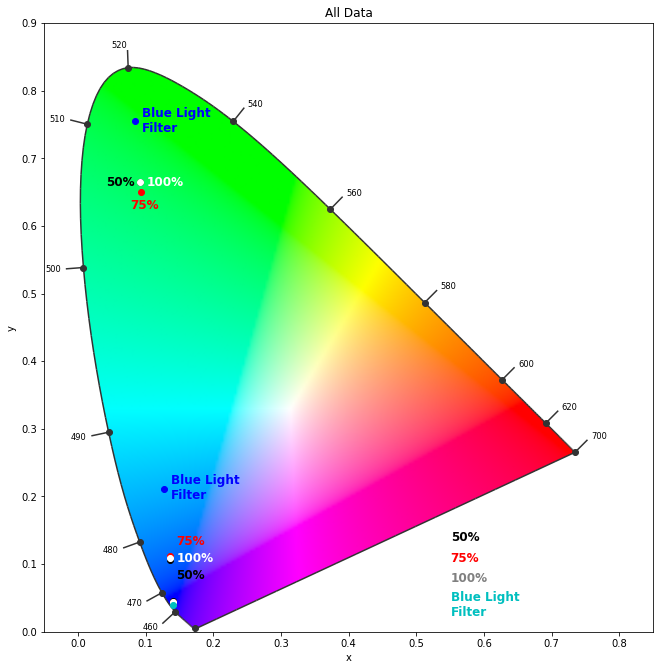

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('All Data')
p.xlabel('x')
p.ylabel('y')
p.axis([-0.05,0.85,0.0,0.9])
#p.axis([0.1,0.2,0.0,0.1])

p.plot(mxyB50[0],mxyB50[1],'ko')
p.plot(mxyB75[0],mxyB75[1],'ro')
p.plot(mxyB100[0],mxyB100[1],'wo')
p.plot(mxyFB[0],mxyFB[1],'co')

xB = mxyB100[0] + 0.4
yB = mxyB100[1]
p.annotate('50%',(xB+0.01,yB+0.09),color='k',fontweight='bold',size=12)
p.annotate('75%',(xB+0.01,yB+0.06),color='r',fontweight='bold',size=12)
p.annotate('100%',(xB+0.01,yB+0.03),color='gray',fontweight='bold',size=12)
p.annotate('Blue Light\nFilter',(xB+0.01,yB-0.02),color='c',fontweight='bold',size=12)

p.plot(mxyC50[0],mxyC50[1],'ko')
p.plot(mxyC75[0],mxyC75[1],'ro')
p.plot(mxyC100[0],mxyC100[1],'wo')
p.plot(mxyFC[0],mxyFC[1],'bo')

p.annotate('50%',(mxyC100[0]+0.01,mxyC100[1]-0.03),color='k',fontweight='bold',size=12)
p.annotate('75%',(mxyC100[0]+0.01,mxyC100[1]+0.02),color='r',fontweight='bold',size=12)
p.annotate('100%',(mxyC100[0]+0.01,mxyC100[1]-0.0055),color='w',fontweight='bold',size=12)
p.annotate('Blue Light\nFilter',(mxyFC[0]+0.01,mxyFC[1]-0.015),color='b',fontweight='bold',size=12)

p.plot(mxyG50[0],mxyG50[1],'ko')
p.plot(mxyG75[0],mxyG75[1],'ro')
p.plot(mxyG100[0],mxyG100[1],'wo')
p.plot(mxyFG[0],mxyFG[1],'bo')

p.annotate('50%',(mxyG50[0]-0.05,mxyG50[1]-0.0055),color='k',fontweight='bold',size=12)
p.annotate('75%',(mxyG75[0]-0.015,mxyG75[1]-0.025),color='r',fontweight='bold',size=12)
p.annotate('100%',(mxyG100[0]+0.01,mxyG100[1]-0.0055),color='w',fontweight='bold',size=12)
p.annotate('Blue Light\nFilter',(mxyFG[0]+0.01,mxyFG[1]-0.015),color='b',fontweight='bold',size=12)

Text(0, 0.5, 'Intensity')

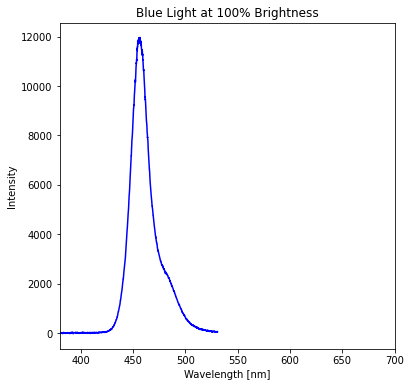

In [ ]:
fig,ax = p.subplots(1,1,figsize=(6,6))
ax.plot(lamB100,specB100,'b-')
ax.set_xlim(380,700)
ax.set_title('Blue Light at 100% Brightness')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Intensity')

###Green

####Overview

Text(0.0943966774404, 0.739586533143, 'Blue Light\nFilter')

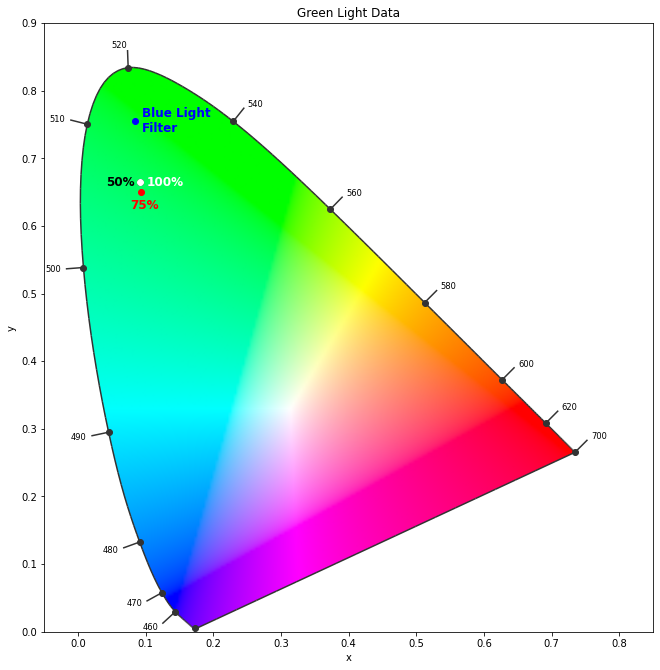

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('Green Light Data')
p.xlabel('x')
p.ylabel('y')
p.axis([-0.05,0.85,0.0,0.9])
#p.axis([0.025,0.175,0.625,0.775])

p.plot(mxyG50[0],mxyG50[1],'ko')
p.plot(mxyG75[0],mxyG75[1],'ro')
p.plot(mxyG100[0],mxyG100[1],'wo')
p.plot(mxyFG[0],mxyFG[1],'bo')

p.annotate('50%',(mxyG50[0]-0.05,mxyG50[1]-0.0055),color='k',fontweight='bold',size=12)
p.annotate('75%',(mxyG75[0]-0.015,mxyG75[1]-0.025),color='r',fontweight='bold',size=12)
p.annotate('100%',(mxyG100[0]+0.01,mxyG100[1]-0.0055),color='w',fontweight='bold',size=12)
p.annotate('Blue Light\nFilter',(mxyFG[0]+0.01,mxyFG[1]-0.015),color='b',fontweight='bold',size=12)

####Zoomed in

Text(0.0893966774404, 0.740586533143, 'Blue Light\nFilter')

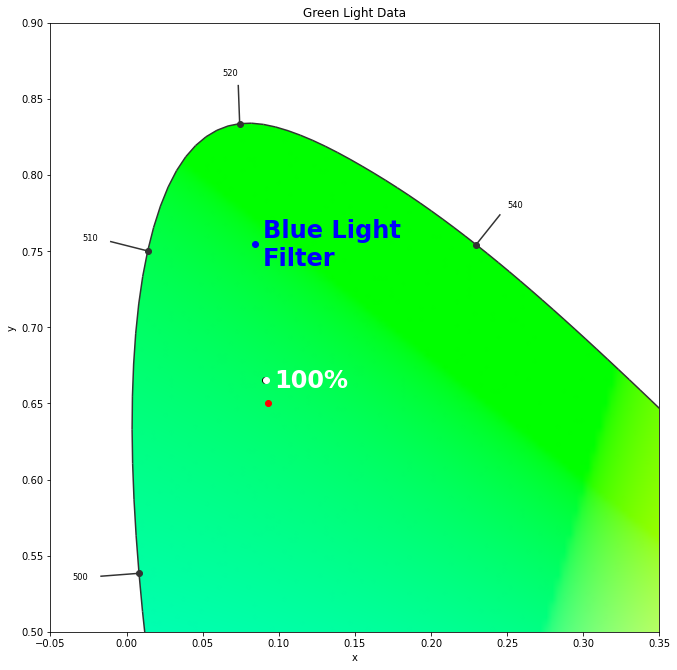

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('Green Light Data')
p.xlabel('x')
p.ylabel('y')
#p.axis([-0.05,0.85,0.0,0.9])
p.axis([-0.05,0.35,0.5,0.9])

p.plot(mxyG50[0],mxyG50[1],'ko')
p.plot(mxyG75[0],mxyG75[1],'ro')
p.plot(mxyG100[0],mxyG100[1],'wo')
p.plot(mxyFG[0],mxyFG[1],'bo')

#p.annotate('50%',(mxyG50[0]-0.045,mxyG50[1]-0.005),color='k',fontweight='bold',size=24)
#p.annotate('75%',(mxyG75[0]-0.015,mxyG75[1]-0.02),color='r',fontweight='bold',size=24)
p.annotate('100%',(mxyG100[0]+0.0055,mxyG100[1]-0.005),color='w',fontweight='bold',size=24)
p.annotate('Blue Light\nFilter',(mxyFG[0]+0.005,mxyFG[1]-0.014),color='b',fontweight='bold',size=24)

###Cyan

####Overview

Text(0.137605300039, 0.196527359932, 'Blue Light\nFilter')

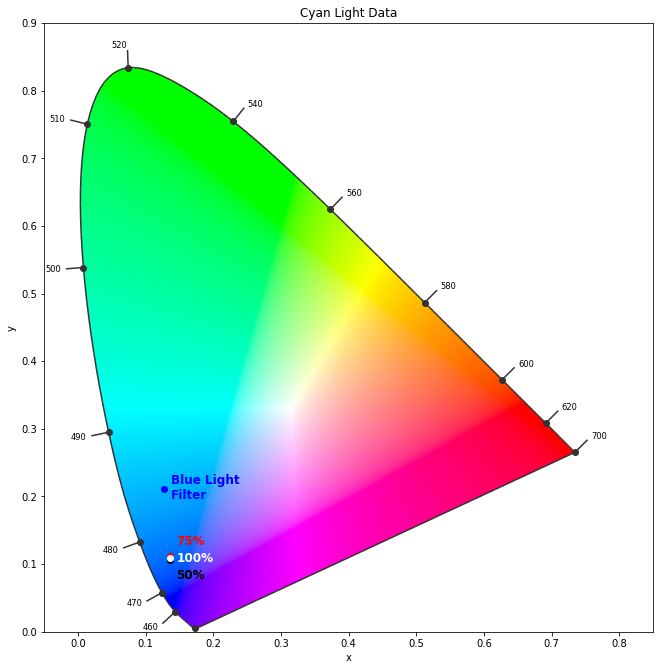

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('Cyan Light Data')
p.xlabel('x')
p.ylabel('y')
p.axis([-0.05,0.85,0.0,0.9])
#p.axis([0.025,0.175,0.625,0.775])

p.plot(mxyC50[0],mxyC50[1],'ko')
p.plot(mxyC75[0],mxyC75[1],'ro')
p.plot(mxyC100[0],mxyC100[1],'wo')
p.plot(mxyFC[0],mxyFC[1],'bo')

p.annotate('50%',(mxyC100[0]+0.01,mxyC100[1]-0.03),color='k',fontweight='bold',size=12)
p.annotate('75%',(mxyC100[0]+0.01,mxyC100[1]+0.02),color='r',fontweight='bold',size=12)
p.annotate('100%',(mxyC100[0]+0.01,mxyC100[1]-0.0055),color='w',fontweight='bold',size=12)
p.annotate('Blue Light\nFilter',(mxyFC[0]+0.01,mxyFC[1]-0.015),color='b',fontweight='bold',size=12)

####Zoomed in

Text(0.137605300039, 0.196527359932, 'Blue Light\nFilter')

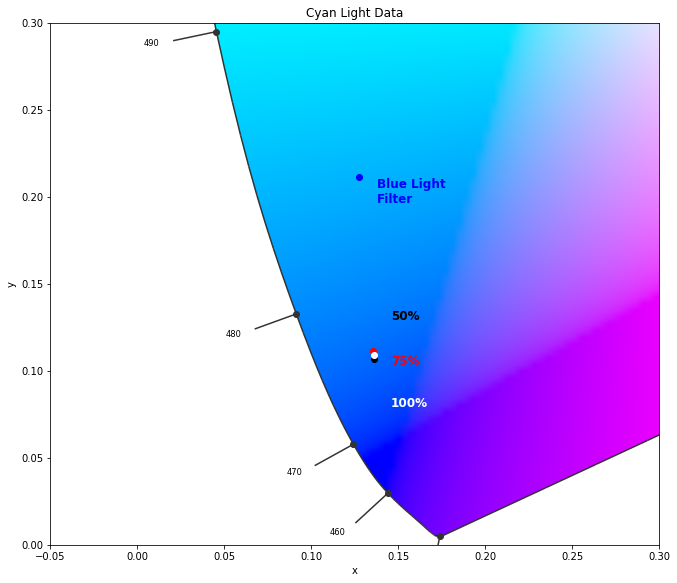

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('Cyan Light Data')
p.xlabel('x')
p.ylabel('y')
#p.axis([-0.05,0.85,0.0,0.9])
p.axis([-0.05,0.3,0.0,0.3])

p.plot(mxyC50[0],mxyC50[1],'ko')
p.plot(mxyC75[0],mxyC75[1],'ro')
p.plot(mxyC100[0],mxyC100[1],'wo')
p.plot(mxyFC[0],mxyFC[1],'bo')

p.annotate('50%',(mxyC100[0]+0.01,mxyC100[1]+0.02),color='k',fontweight='bold',size=12)
p.annotate('75%',(mxyC100[0]+0.01,mxyC100[1]-0.0055),color='r',fontweight='bold',size=12)
p.annotate('100%',(mxyC100[0]+0.01,mxyC100[1]-0.03),color='w',fontweight='bold',size=12)
p.annotate('Blue Light\nFilter',(mxyFC[0]+0.01,mxyFC[1]-0.015),color='b',fontweight='bold',size=12)

###Blue

####Overview

Text(0.150912461995, 0.0240118003608, 'Blue Light\nFilter')

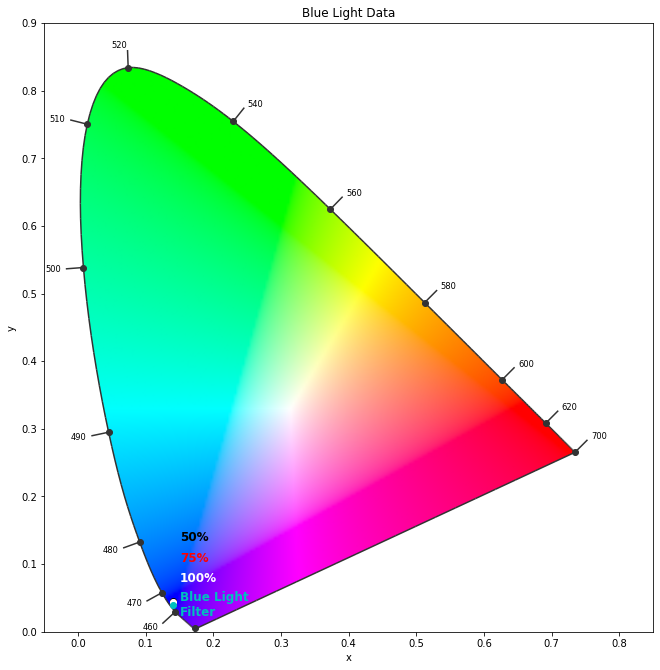

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('Blue Light Data')
p.xlabel('x')
p.ylabel('y')
p.axis([-0.05,0.85,0.0,0.9])
#p.axis([0.1,0.2,0.0,0.1])

p.plot(mxyB50[0],mxyB50[1],'ko')
p.plot(mxyB75[0],mxyB75[1],'ro')
p.plot(mxyB100[0],mxyB100[1],'wo')
p.plot(mxyFB[0],mxyFB[1],'co')

p.annotate('50%',(mxyB100[0]+0.01,mxyB100[1]+0.09),color='k',fontweight='bold',size=12)
p.annotate('75%',(mxyB100[0]+0.01,mxyB100[1]+0.06),color='r',fontweight='bold',size=12)
p.annotate('100%',(mxyB100[0]+0.01,mxyB100[1]+0.03),color='w',fontweight='bold',size=12)
p.annotate('Blue Light\nFilter',(mxyB100[0]+0.01,mxyB100[1]-0.02),color='c',fontweight='bold',size=12)

####Zoomed in

Text(0.150912461995, 0.0240118003608, 'Blue Light\nFilter')

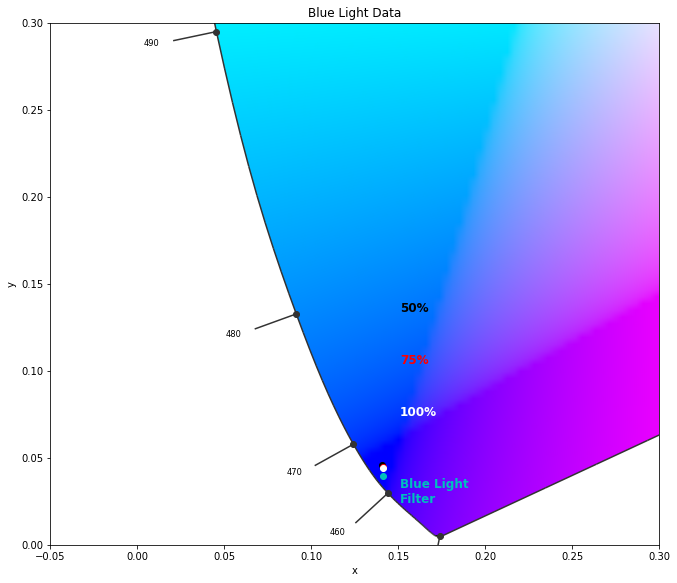

In [ ]:
col.plotting.chromaticity_diagram_plot_CIE1931(standalone=False)
fig = p.gcf()
fig.set_size_inches(10,10)
p.title('Blue Light Data')
p.xlabel('x')
p.ylabel('y')
#p.axis([-0.05,0.85,0.0,0.9])
p.axis([-0.05,0.3,0.0,0.3])

p.plot(mxyB50[0],mxyB50[1],'ko')
p.plot(mxyB75[0],mxyB75[1],'ro')
p.plot(mxyB100[0],mxyB100[1],'wo')
p.plot(mxyFB[0],mxyFB[1],'co')

p.annotate('50%',(mxyB100[0]+0.01,mxyB100[1]+0.09),color='k',fontweight='bold',size=12)
p.annotate('75%',(mxyB100[0]+0.01,mxyB100[1]+0.06),color='r',fontweight='bold',size=12)
p.annotate('100%',(mxyB100[0]+0.01,mxyB100[1]+0.03),color='w',fontweight='bold',size=12)
p.annotate('Blue Light\nFilter',(mxyB100[0]+0.01,mxyB100[1]-0.02),color='c',fontweight='bold',size=12)

#Color Quality

##Using my method

In [ ]:
print(ColorQuality(xy05,0.01))
print(ColorQuality(xy1,0.01))
print(ColorQuality(xy2,0.01))
print(ColorQuality(xy4,0.01))
print(ColorQuality(xy6,0.01))
print(ColorQuality(xyO,0.01))
print(ColorQuality(xySun,0.01))

(599.20361557251908, 489.82343761061946, 0.45406185924694248)
The point you have given has a dominant wavelength that does not exist.
(nan, 497.46517473684207, 0.071296887605731787)
(599.60154839694655, 489.92422079646019, 0.7739544929946931)
(599.09418404580151, 489.79320265486729, 0.70260118210223244)
(606.05800847328248, 491.15377566371683, 0.91241507714179659)
The point you have given has a complementary wavelength that does not exist.
(546.97152747540986, nan, 0.76370695176345693)
(490.78087787610616, 603.83953297709922, 0.033515465811603834)


##Using Color Package

In [ ]:
print(col.dominant_wavelength(xy05,WhitePoint)[0],col.complementary_wavelength(xy05,WhitePoint)[0],col.excitation_purity(xy05,WhitePoint))
print(col.dominant_wavelength(xy1,WhitePoint)[0],col.complementary_wavelength(xy1,WhitePoint)[0],col.excitation_purity(xy1,WhitePoint))
print(col.dominant_wavelength(xy2,WhitePoint)[0],col.complementary_wavelength(xy2,WhitePoint)[0],col.excitation_purity(xy2,WhitePoint))
print(col.dominant_wavelength(xy4,WhitePoint)[0],col.complementary_wavelength(xy4,WhitePoint)[0],col.excitation_purity(xy4,WhitePoint))
print(col.dominant_wavelength(xy6,WhitePoint)[0],col.complementary_wavelength(xy6,WhitePoint)[0],col.excitation_purity(xy6,WhitePoint))
print(col.dominant_wavelength(xyO,WhitePoint)[0],col.complementary_wavelength(xyO,WhitePoint)[0],col.excitation_purity(xyO,WhitePoint))
print(col.dominant_wavelength(xySun,WhitePoint)[0],col.complementary_wavelength(xySun,WhitePoint)[0],col.excitation_purity(xySun,WhitePoint))

599.0 490.0 0.453893527354
-497.0 497.0 0.0710660383843
600.0 490.0 0.773297255672
599.0 490.0 0.702576353486
606.0 491.0 0.912486379489
547.0 -547.0 0.762459496465
491.0 604.0 0.0335177396339


#Results

In [ ]:
eps = 0.001

print('Blue')
print('  Color')
print('50%')
print(xyB50)
print('75%')
print(xyB75)
print('100%')
print(xyB100)
print('Filter')
print(xyFB)
print('')
print('  Mine')
print('50%')
print(mxyB50)
print('75%')
print(mxyB75)
print('100%')
print(mxyB100)
print('Filter')
print(mxyFB)
print(' Color Quality')
print('50%')
print(ColorQuality(mxyB50,eps))
print('75%')
print(ColorQuality(mxyB75,eps))
print('100%')
print(ColorQuality(mxyB100,eps))
print('Filter')
print(ColorQuality(mxyFB,eps))
print('')
print('')
print('Cyan')
print('  Color')
print('50%')
print(xyC50)
print('75%')
print(xyC75)
print('100%')
print(xyC100)
print('Filter')
print(xyFC)
print('')
print('  Mine')
print('50%')
print(mxyC50)
print('75%')
print(mxyC75)
print('100%')
print(mxyC100)
print('Filter')
print(mxyFC)
print(' Color Quality')
print('50%')
print(ColorQuality(mxyC50,eps))
print('75%')
print(ColorQuality(mxyC75,eps))
print('100%')
print(ColorQuality(mxyC100,eps))
print('Filter')
print(ColorQuality(mxyFC,eps))
print('')
print('')
print('Green')
print('  Color')
print('50%')
print(xyG50)
print('75%')
print(xyG75)
print('100%')
print(xyG100)
print('Filter')
print(xyFG)
print('')
print('  Mine')
print('50%')
print(mxyG50)
print('75%')
print(mxyG75)
print('100%')
print(mxyG100)
print('Filter')
print(mxyFG)
print(' Color Quality')
print('50%')
print(ColorQuality(mxyG50,eps))
print('75%')
print(ColorQuality(mxyG75,eps))
print('100%')
print(ColorQuality(mxyG100,eps))
print('Filter')
print(ColorQuality(mxyFG,eps))

Blue
  Color
50%
[ 0.15662974  0.06617303]
75%
[ 0.14683651  0.05210898]
100%
[ 0.14712619  0.05213285]
Filter
[ 0.14051223  0.0395341 ]

  Mine
50%
(0.14067305889292137, 0.046115848659591202)
75%
(0.14096015406508478, 0.044660791921580872)
100%
(0.14091246199475346, 0.044011800360786675)
Filter
(0.14124778663869958, 0.03975586774994673)
 Color Quality
50%
(464.73043999999999, 573.24645743511451, 0.97641623915283715)
75%
(464.36862836283183, 573.17383469465653, 0.97834988045246585)
100%
(464.25978252212388, 573.15692254961834, 0.97964933701359991)
Filter
(463.28621694690264, 572.96690962595426, 0.98667059206063523)


Cyan
  Color
50%
[ 0.26769719  0.23540884]
75%
[ 0.26669757  0.23844422]
100%
[ 0.26475567  0.23490638]
Filter
[ 0.34270388  0.35974291]

  Mine
50%
(0.13608029665422858, 0.10670471202754456)
75%
(0.13560591663274035, 0.11151595094853999)
100%
(0.1357538106704681, 0.10925038906114265)
Filter
(0.12760530003906109, 0.21152735993229554)
 Color Quality
50%
(474.00551659292034,